In [1]:
import numpy as np
import random
from PIL import Image
import networkx as nx
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
%matplotlib widget

from cubic_spline_fit import CubicSpline2D, cubic_func
from extract_network import find_color, extract_network, render_skeleton, render_network

/home/ss/anaconda3/envs/extract_raster/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def image_to_graph(img: Image, simplify: bool=True) -> nx.Graph:
    rgb = (255, 255, 255)
    px = find_color(img, rgb).T
    return extract_network(px, min_distance=4, simplify=simplify)

def graph_to_polylines(g: nx.Graph, simplify: bool=True) -> list:
    polylines = []
    for (n1, n2, k) in g.edges(keys=True):
        edge = g[n1][n2][k]
        path = edge['path']
        if simplify:
            coords = np.array(path.coords)
        else:
            coords = np.array(path)
        polylines.append(coords)
    return polylines


img_id = 1
png_file = f'samples/gt/{img_id}_gray.png'
img = Image.open(png_file)

simplify = False
skel, graph = image_to_graph(img, simplify=simplify)
polylines = graph_to_polylines(graph, simplify=simplify)

Skeleton px=6322
Adding 13/24 dense nodes to existing 307 nodes.
Extracted street network:
  - 152 nodes
  - 366 edges


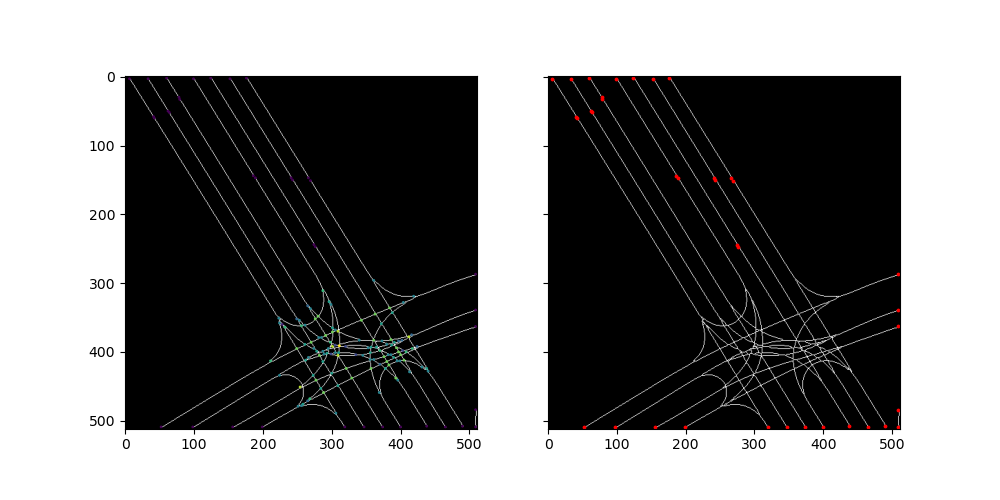

In [15]:
# def generate_frenet_frame(centerline_pts: np.ndarray):
def generate_frenet_frame(xs: np.ndarray, ys: np.ndarray):
    cubic_spline = CubicSpline2D(xs, ys)
    s = np.arange(0, cubic_spline.s[-1], 1)
    ref_xy = [cubic_spline.calc_position(i_s) for i_s in s]
    ref_yaw = [cubic_spline.calc_yaw(i_s) for i_s in s]
    ref_rk = [cubic_spline.calc_curvature(i_s) for i_s in s]
    return cubic_spline, np.column_stack((ref_xy, ref_yaw, ref_rk))

def connect_small_gaps(graph: nx.Graph, nodes: np.ndarray, thresh: int=4) -> nx.Graph:
    gap_pairs = []
    for n1 in nodes:
        for n2 in nodes:
            if n1 != n2:
                dist = np.hypot(n1[0] - n2[0], n1[1] - n2[1])
                if dist <= thresh:
                    gap_pairs.append([n1, n2])


    # nodes_neighbors = nx.neighbors(graph, node)

    return graph

def find_terminal_nodes(graph: nx.Graph) -> np.ndarray:
    nodes_terminal = np.array([(node[0], node[1], i) for i, (node, degree) in enumerate(graph.degree) if degree == 1], dtype=float)
    print(f'Found {nodes_terminal.shape[0]} terminal nodes (nodes with only 1 degree connection)')

    return nodes_terminal
    

def connect_terminal_nodes(graph: nx.Graph) -> nx.Graph:

    fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
    axes = axes.ravel()

    nodes = np.array([node for (node, degree) in graph.degree()], dtype=float)
    degrees = np.array([degree for (node, degree) in graph.degree()], dtype=float)

    nodes_terminal = find_terminal_nodes(graph)

    axes[0].imshow(skel, cmap='gray')
    axes[0].scatter(nodes[:, 1], nodes[:, 0], c=degrees, s=1)

    axes[1].imshow(skel, cmap='gray')
    axes[1].scatter(nodes_terminal[:, 1], nodes_terminal[:, 0], c='red', s=3)

    axes[0].set_aspect('equal')
    axes[1].set_aspect('equal')

    plt.show()
    
    return graph


connect_terminal_nodes(graph)

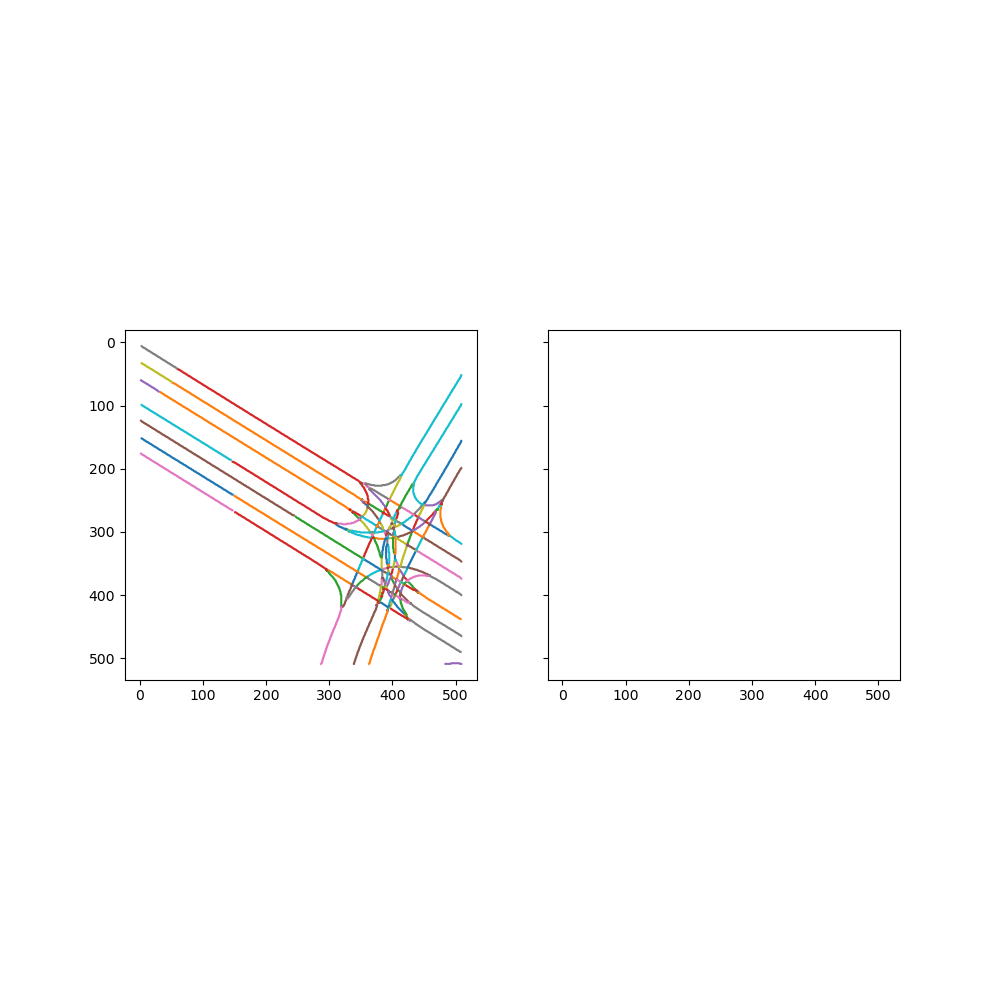

In [4]:
def plot_polylines(polylines: list) -> None:
    fig, axes = plt.subplots(1, 2, figsize=(10, 10), sharex=True, sharey=True)
    axes = axes.ravel()

    def random_color():
        return '#{:02X}{:02X}{:02X}'.format(random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
    
    def generate_random_colors(n):
        return [random_color() for _ in range(n)]

    color = generate_random_colors(len(polylines))

    for i, polyline in enumerate(polylines):
        xs = polyline[:, 0]
        ys = polyline[:, 1]
        axes[0].plot(xs, ys)

        # cubic_spline, ref_curve = generate_frenet_frame(xs, ys)
        # dy = np.sin(ref_curve[:, 2]) / 5
        # dx = np.cos(ref_curve[:, 2]) / 5
        # axes[1].quiver(ref_curve[:, 0], ref_curve[:, 1], dx, dy, color=color[i], angles='xy', scale_units='xy', scale=0.1)

    # img_skeleton = render_skeleton(img, skel, (255, 0, 0))
    # img_network = render_network(img, g, (0, 255, 0))
    # axes[0].imshow(img_skeleton)
    # axes[1].imshow(img_network)
    axes[0].set_aspect('equal')
    axes[0].invert_yaxis()
    axes[1].set_aspect('equal')
    plt.show()

    return

plot_polylines(polylines)